In [1]:
import cv2
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

In [2]:
labels = os.listdir(r"D:\\DDD\\DL_Driver-drowsiness-detection-main\\DL_Driver-drowsiness-detection-main\\data\\train")

In [3]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

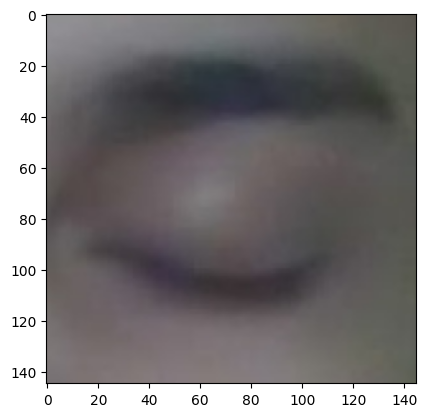

In [4]:
plt.imshow(plt.imread(r"D:\\DDD\\DL_Driver-drowsiness-detection-main\\DL_Driver-drowsiness-detection-main\\data\\train\\Closed\\_3.jpg"))

In [5]:
a = plt.imread(r"D:\DDD\\DL_Driver-drowsiness-detection-main\\DL_Driver-drowsiness-detection-main\\data\\train\\yawn\\42.jpg")

In [6]:
a.shape

(480, 640, 3)

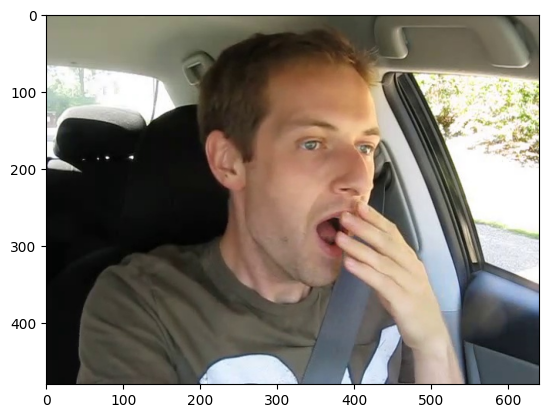

In [7]:
plt.imshow(plt.imread(r"D:\DDD\\DL_Driver-drowsiness-detection-main\\DL_Driver-drowsiness-detection-main\\data\\train\\yawn\\42.jpg"))

In [8]:
def face_for_yawn(direc=r"D:\\DDD\\DL_Driver-drowsiness-detection-main\\DL_Driver-drowsiness-detection-main\\data\\train", face_cas_path=r"D:\\DDD\\DL_Driver-drowsiness-detection-main\\DL_Driver-drowsiness-detection-main\\haarcascade\\haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [9]:
def get_data(dir_path=r"D:\\DDD\\DL_Driver-drowsiness-detection-main\\DL_Driver-drowsiness-detection-main\\data\\train", face_cas=r"D:\\DDD\\DL_Driver-drowsiness-detection-main\\DL_Driver-drowsiness-detection-main\\haarcascade\\haarcascade_frontalface_default.xml", eye_cas=r"haarcascade\\haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [10]:
data_train = get_data()

2
3


In [12]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [13]:
new_data = append_data()

0
1
2
3


C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_448\2804427426.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [14]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [15]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [16]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [17]:
y = np.array(y)

In [18]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [19]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [20]:
len(X_test)

578

In [23]:
from keras.preprocessing.image import ImageDataGenerator

In [53]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [54]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [55]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 71, 71, 256)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 64)      

In [56]:
#from tensorflow.keras.callbacks import TensorBoard
#log_dir = os.path.join('Logs') #log folder 
#tb_callback = TensorBoard(log_dir=log_dir)

In [57]:
#from tensorflow.keras.callbacks import TensorBoard

In [58]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator),callbacks=[tb_callback])


Epoch 1/10
43/43 [==============================] - 131s 3s/step - loss: 1.2902 - accuracy: 0.3920 - val_loss: 1.2132 - val_accuracy: 0.4100
Epoch 2/10
43/43 [==============================] - 115s 3s/step - loss: 0.6935 - accuracy: 0.6956 - val_loss: 0.4582 - val_accuracy: 0.8529
Epoch 3/10
43/43 [==============================] - 108s 3s/step - loss: 0.4056 - accuracy: 0.8359 - val_loss: 0.3921 - val_accuracy: 0.8356
Epoch 4/10
43/43 [==============================] - 109s 3s/step - loss: 0.3390 - accuracy: 0.8508 - val_loss: 0.2998 - val_accuracy: 0.8806
Epoch 5/10
43/43 [==============================] - 104s 2s/step - loss: 0.3096 - accuracy: 0.8723 - val_loss: 0.2367 - val_accuracy: 0.8979
Epoch 6/10
43/43 [==============================] - 112s 3s/step - loss: 0.2846 - accuracy: 0.8723 - val_loss: 0.2772 - val_accuracy: 0.8806
Epoch 7/10
43/43 [==============================] - 108s 3s/step - loss: 0.2324 - accuracy: 0.8990 - val_loss: 0.2153 - val_accuracy: 0.8979
Epoch 8/10
43

In [35]:
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir C:\Users\PREDATOR\Logs\train

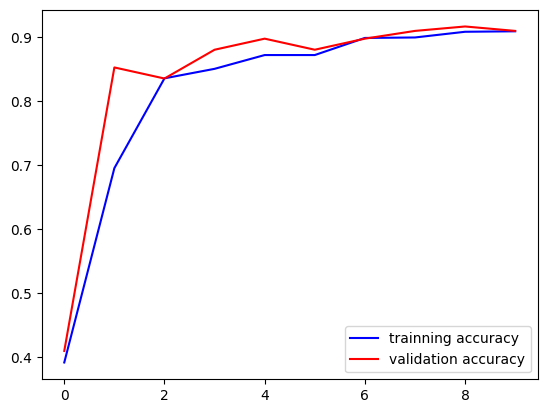

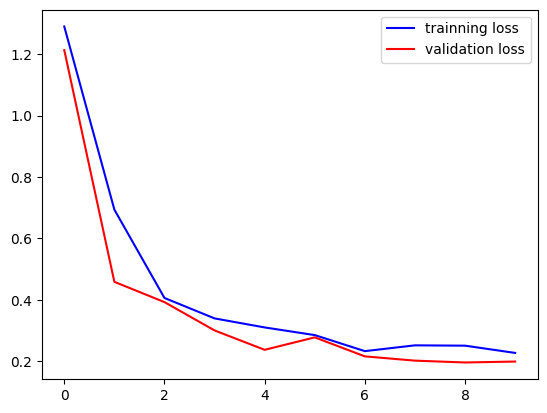

In [59]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [62]:
model.save("model_best.h5")

In [63]:
prediction = model.predict(X_test)
print(prediction)

19/19 [==============================] - 11s 557ms/step
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [66]:
import numpy as np
from sklearn.metrics import classification_report

In [67]:
y_test_labels = np.argmax(y_test, axis=1)
predicted_classes = np.argmax(prediction, axis=1)
print(classification_report(y_test_labels, predicted_classes, target_names=labels))

              precision    recall  f1-score   support

      Closed       0.94      0.49      0.65        63
     no_yawn       0.69      0.82      0.75        74
        Open       0.74      0.98      0.84       215
        yawn       0.99      0.76      0.86       226

    accuracy                           0.82       578
   macro avg       0.84      0.76      0.78       578
weighted avg       0.86      0.82      0.82       578

